Copyright 2023 Borislav Rumenov Varbanov

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Simplified 2D GPU Pipeline with Basic Memory Handling
#### Components:
##### Memory:
Stores vertices, transformed vertices, tile lists, and the final image.
##### Vertex Shader:
Transforms vertices and stores them back in memory.
##### Tiler:
Creates tile lists based on transformed vertices.
##### Fragment Shader:
Outputs a solid color for each pixel within the triangle.
##### Rasterization:
Fills in each tile's pixels using the fragment shader and stores the final image.
## Overview:
This example demonstrates a basic 2D GPU rendering pipeline. It employs a simple Memory class to handle data storage at each stage of the pipeline. The pipeline transforms vertices, creates tile lists for rasterization, and produces a final image using a simple fragment shader. This basic pipeline serves as a foundation for understanding key aspects of GPU design and data handling.

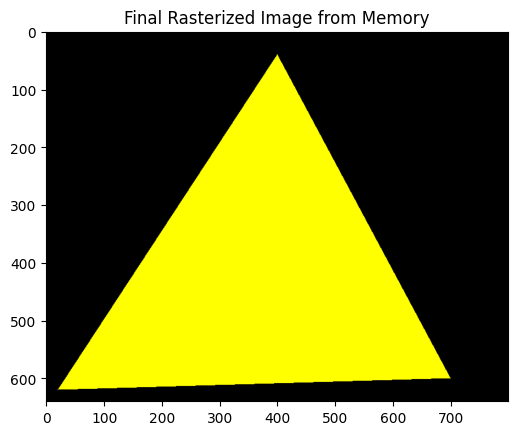

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_res = 800
y_res = 640

class Memory:
    def __init__(self):
        self.vertices = []
        self.transformed_vertices = []
        self.tile_lists = []
        self.image = None

    def store_vertices(self, vertices):
        self.vertices = vertices

    def load_vertices(self):
        return self.vertices

    def store_transformed_vertices(self, transformed_vertices):
        self.transformed_vertices = transformed_vertices

    def load_transformed_vertices(self):
        return self.transformed_vertices

    def store_tile_lists(self, tile_lists):
        self.tile_lists = tile_lists

    def load_tile_lists(self):
        return self.tile_lists

    def store_image(self, image):
        self.image = image

    def load_image(self):
        return self.image


class VertexShaderWithMemory:
    def process(self, memory):
        vertices = memory.load_vertices()
        transformed_vertices = [self.transform_vertex(v) for v in vertices]
        memory.store_transformed_vertices(transformed_vertices)

    def transform_vertex(self, vertex):
        return vertex * 0.5


class TilerWithMemory:
    def process(self, memory, tile_size=32):
        transformed_vertices = memory.load_transformed_vertices()
        tile_lists = self.create_tile_lists(transformed_vertices, tile_size)
        memory.store_tile_lists(tile_lists)

    def create_tile_lists(self, vertices, tile_size):
        tile_lists = []
        for y in range(0, y_res, tile_size):
            for x in range(0, x_res, tile_size):
                tile = {'min_x': x, 'min_y': y, 'max_x': x + tile_size, 'max_y': y + tile_size}
                tile_lists.append(tile)
        return tile_lists

class FragmentShader:
    def process(self, x, y):
        # Return a solid color for the triangle (red in this case)
        return [255, 255, 0]

class RasterizationWithMemory:
    def process(self, memory):
        tile_lists = memory.load_tile_lists()
        image = np.zeros((y_res, x_res, 3), dtype=np.uint8)
        for tile in tile_lists:
            self.rasterize_tile(tile, image, memory)
        memory.store_image(image)

    def rasterize_tile(self, tile, image, memory):
        v0, v1, v2 = memory.load_transformed_vertices()
        fragment_shader = FragmentShader()
        for y in range(tile['min_y'], tile['max_y']):
            for x in range(tile['min_x'], tile['max_x']):
                w0 = (v1[1] - v2[1]) * (x - v2[0]) + (v2[0] - v1[0]) * (y - v2[1])
                w1 = (v2[1] - v0[1]) * (x - v0[0]) + (v0[0] - v2[0]) * (y - v0[1])
                w2 = (v0[1] - v1[1]) * (x - v1[0]) + (v1[0] - v0[0]) * (y - v1[1])
                if w0 >= 0 and w1 >= 0 and w2 >= 0:
                    color = fragment_shader.process(x, y)
                    image[y, x] = color

# Define the vertices of the triangle
v0 = np.array([800, 80])
v1 = np.array([1400, 1200])
v2 = np.array([40, 1240])

# Create memory and store the vertices
memory = Memory()
memory.store_vertices([v0, v1, v2])

# Apply vertex shader
vertex_shader = VertexShaderWithMemory()
vertex_shader.process(memory)

# Create tile lists
tiler = TilerWithMemory()
tiler.process(memory)

# Rasterize the primitives
rasterization = RasterizationWithMemory()
rasterization.process(memory)

# Load and display the final image
final_image = memory.load_image()
plt.imshow(final_image / 255.0)
plt.title('Final Rasterized Image from Memory')
plt.show()
# Store the final image as a PNG file
plt.imsave("simple_example_final_image.png", final_image / 255.0)


## Example 2D GPU with Extended Memory and Vertex Color Interpolation
This example demonstrates an enhanced version of a typical 2D GPU rendering pipeline, featuring vertex color storage, barycentric color interpolation, and memory interactions.
Components:
#### Extended Memory:
Stores vertices, transformed vertices, tile lists, vertex colors, and the final image.
Vertex colors are a new addition, allowing per-vertex color attributes to be stored and accessed later in the pipeline.
#### Vertex Shader:
Loads vertices from extended memory, transforms them, and stores the transformed vertices back in extended memory.
The operation remains the same as in the basic version but utilizes the Extended Memory class.
#### Tiler:
Loads transformed vertices from extended memory, creates tile lists, and stores them in extended memory.
Also, similar to the basic version, but makes use of Extended Memory.
#### Fragment Shader with Memory:
Takes barycentric coordinates and extended memory as input.
Uses the vertex colors from extended memory and barycentric coordinates for color interpolation.
Outputs the color for each pixel in the rasterization process.
#### Rasterization with Barycentric Color Interpolation:
Loads tile lists and vertex colors from extended memory.
Rasterizes the primitives within each tile.
Utilizes the Fragment Shader with Memory to obtain interpolated colors for each pixel.
Stores the final, color-interpolated image back into extended memory.
## Overview:
This example builds upon a simplified GPU rendering pipeline by incorporating vertex color attributes and barycentric color interpolation. These features allow for more visually nuanced output and demonstrate how additional attributes can be seamlessly integrated into the pipeline. The pipeline also showcases effective memory interactions for storing various types of data, which can be a crucial part of efficient GPU design and verification.

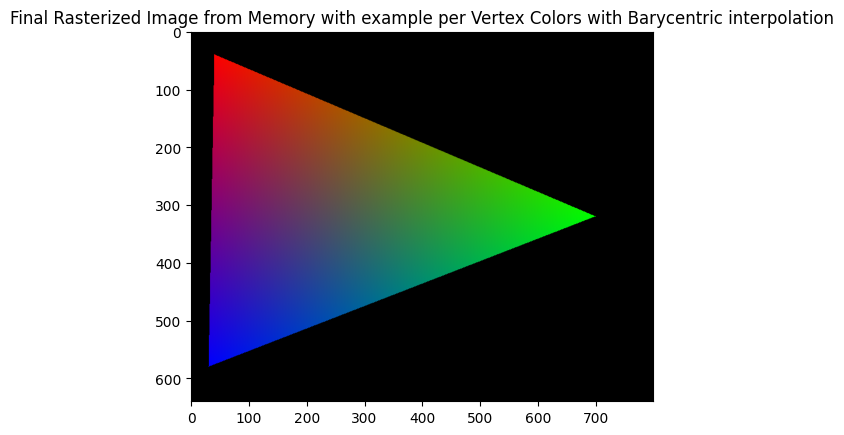

In [2]:
class ExtendedMemory(Memory):
    def __init__(self):
        super().__init__()
        self.vertex_colors = []

    def store_vertex_colors(self, vertex_colors):
        self.vertex_colors = vertex_colors

    def load_vertex_colors(self):
        return self.vertex_colors


class FragmentShaderWithMemory(FragmentShader):
    def process(self, x, y, w0, w1, w2, memory):
        vertex_colors = np.array(memory.load_vertex_colors())  # Load RGB vertex colors
        color = w0 * vertex_colors[0] + w1 * vertex_colors[1] + w2 * vertex_colors[2]
        return color.astype(int)  # Return the interpolated color


class RasterizationWithInterpAndMemory:
    def process(self, memory):
        tile_lists = memory.load_tile_lists()
        image = np.zeros((y_res, x_res, 3), dtype=np.uint8)
        fragment_shader = FragmentShaderWithMemory()
        for tile in tile_lists:
            self.rasterize_tile(tile, image, memory, fragment_shader)
        memory.store_image(image)  # Make sure this line is executed to store the image

    def rasterize_tile(self, tile, image, memory, fragment_shader):
        v0, v1, v2 = memory.load_transformed_vertices()

        for y in range(tile['min_y'], tile['max_y']):
            for x in range(tile['min_x'], tile['max_x']):
                w0 = (v1[1] - v2[1]) * (x - v2[0]) + (v2[0] - v1[0]) * (y - v2[1])
                w1 = (v2[1] - v0[1]) * (x - v0[0]) + (v0[0] - v2[0]) * (y - v0[1])
                w2 = (v0[1] - v1[1]) * (x - v1[0]) + (v1[0] - v0[0]) * (y - v1[1])

                if w0 >= 0 and w1 >= 0 and w2 >= 0:
                    w_sum = w0 + w1 + w2
                    w0 /= w_sum
                    w1 /= w_sum
                    w2 /= w_sum
                    color = fragment_shader.process(x, y, w0, w1, w2, memory)
                    image[y, x] = color

# Vertex and color definitions
v0 = np.array([80, 80])
v1 = np.array([1400, 640])
v2 = np.array([60, 1160])
vertex_colors = [np.array([255, 0, 0]), np.array([0, 255, 0]), np.array([0, 0, 255])]  # RGB

# Store vertices and colors in memory
memory = ExtendedMemory()
memory.store_vertices([v0, v1, v2])
memory.store_vertex_colors(vertex_colors)

# Other processing steps
vertex_shader = VertexShaderWithMemory()
vertex_shader.process(memory)
tiler = TilerWithMemory()
tiler.process(memory)
rasterization = RasterizationWithInterpAndMemory()
rasterization.process(memory)

# Display the final image
final_image = memory.load_image()
plt.imshow(final_image / 255.0)
plt.title('Final Rasterized Image from Memory with example per Vertex Colors with Barycentric interpolation')
plt.show()
# Store the final image as a PNG file
plt.imsave("interpolation_example_final_image.png", final_image / 255.0)
